# Доверительные интервалы на основе bootstrap

In [1]:
import numpy as np
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

### Время ремонта телекоммуникаций

Verizon — основная региональная телекоммуникационная компания (Incumbent Local Exchange Carrier, ILEC) в западной 
части США. В связи с этим данная компания обязана предоставлять сервис ремонта телекоммуникационного оборудования 
не только для своих клиентов, но и для клиентов других локальных телекоммуникационых компаний (Competing Local Exchange Carriers, CLEC). При этом в случаях, когда время ремонта оборудования для клиентов других компаний существенно выше, чем для собственных, Verizon может быть оштрафована. 

In [3]:
data = pd.read_csv('challenger.txt', sep='\t')
data.shape

(23, 3)

In [8]:
data.describe()

,Temperature,Incident
count,23.000000,23.000000
mean,20.860870,0.304348
std,3.919501,0.470472
min,11.700000,0.000000
25%,19.400000,0.000000
50%,21.100000,0.000000
75%,23.900000,1.000000
max,27.200000,1.000000


In [6]:
data.Incident.value_counts()

0    16
1     7
Name: Incident, dtype: int64

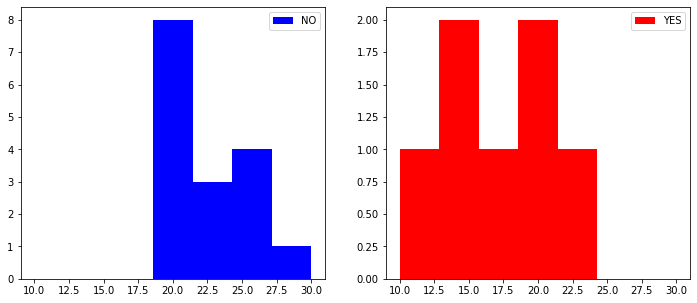

In [10]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.Incident == 0].Temperature, bins = 7, color = 'b', range = (10, 30), label = 'NO')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.Incident == 1].Temperature, bins = 7, color = 'r', range = (10, 30), label = 'YES')
pylab.legend()

pylab.show()

## Bootstrap

In [11]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [12]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

### Интервальная оценка медианы

In [13]:
no_temp = data[data.Incident == 0].Temperature.values
yes_temp = data[data.Incident == 1].Temperature.values

In [14]:
np.random.seed(0)

no_temp_mean_scores = list(map(np.mean, get_bootstrap_samples(no_temp, 1000)))
yes_temp_mean_scores = list(map(np.mean, get_bootstrap_samples(yes_temp, 1000)))

print("95% confidence interval for no crash",  stat_intervals(no_temp_mean_scores, 0.05))
print("95% confidence interval for crash:",  stat_intervals(yes_temp_mean_scores, 0.05))

95% confidence interval for no crash [21.06875  23.575625]
95% confidence interval for crash: [14.5125     20.71607143]


### Точечная оценка разности медиан

In [15]:
print("difference between means:", np.mean(no_temp) - np.mean(yes_temp))

difference between means: 4.666964285714283


### Интервальная оценка разности медиан

In [18]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(no_temp_mean_scores, yes_temp_mean_scores)))

In [20]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [1.42299107 7.93861607]


In [21]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [25]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [26]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

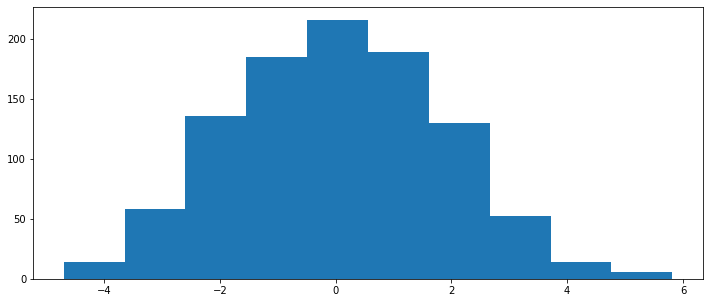

In [30]:
pylab.hist(permutation_zero_dist_ind(no_temp, yes_temp, max_combinations = 1000))
pylab.show()

In [31]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [32]:
np.random.seed(0)

print("p-value: %.4f" % permutation_test(no_temp, yes_temp, max_permutations = 10000))

p-value: 0.0070
